In [104]:
import cv2
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report
from skimage.feature import local_binary_pattern
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import AdditiveChi2Sampler
import pickle
from sklearn.svm import SVC
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV


In [20]:
train_folder='TRAIN'
test_folder='TEST'

emotion_mapping={"01": "Neutral","02": "Calm","03": "Happy","04": "Sad","05": "Angry","06": "Fearful","07": "Disgust","08": "Surprised"}



In [21]:
def face_detection(one_frame):
    haar_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    face_cascade = cv2.CascadeClassifier(haar_cascade_path)
    gray = cv2.cvtColor(one_frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces


In [22]:
def video_processing(video_path):
    video_capture=cv2.VideoCapture(video_path)
    LBP_features=[]
    while video_capture.isOpened():
        ret, frame=video_capture.read()
        if not ret:
            break
        faces=face_detection(frame)  #detecting faces-> faces are the detected faces which can now be used to extract lbp features
        # Extract features for each face
        for (x, y, w, h) in faces:
            face = frame[y:y+h, x:x+w]
            face_resized = cv2.resize(face, (128, 128))
           
            gray = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)
            lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 27), density=True) #hist is the lbp feature extracted
            LBP_features.append(hist)
    video_capture.release()
    return np.mean(LBP_features, axis=0) if LBP_features else np.zeros((26,))



        

In [29]:
x=[]
y=[]
max_vids=300
current=0
odd=0
for actor_folder in os.listdir(train_folder):
    if current >= max_vids:  # Stop once the total videos processed reaches the limit
        break
    actor_path=os.path.join(train_folder, actor_folder)
    if  os.path.isdir(actor_path):
        for video in os.listdir(actor_path):
                if current >= max_vids:  # Stop once the total videos processed reaches the limit
                  break
                odd+=1
                if odd%2==0:
                    continue
                video_path_train=os.path.join(actor_path, video)
                emotion_number=video.split("-")[2]
                emotion_value=emotion_mapping[emotion_number]
                print(f"Processing video: {video_path_train}")
                features_after_processing=video_processing(video_path_train)
                x.append(features_after_processing)
                y.append(emotion_value)
                current+=1
                
                

Processing video: TRAIN\Actor_01\01-01-01-01-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-01-01-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-02-01-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-02-01-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-02-02-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-02-02-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-03-01-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-03-01-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-03-02-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-03-02-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-04-01-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-04-01-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-04-02-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-04-02-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-05-01-01-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-05-01-02-01-01.mp4
Processing video: TRAIN\Actor_01\01-01-05-02-01-01-01.mp4
Processing vid

In [30]:
X_train=np.array(x)
Y_train=np.array(y)

In [40]:
v=[]
w=[]
max_vids=120
current=0
odd=0
for actor_folder in os.listdir(test_folder):
    if current >= max_vids: 
        break
    actor_path=os.path.join(test_folder, actor_folder)
    if  os.path.isdir(actor_path):
        for video in os.listdir(actor_path):
                if current >= max_vids:
                  break
                odd+=1
                if odd%2==0:
                    continue
                video_path_test=os.path.join(actor_path, video)
                emotion_number=video.split("-")[2]
                emotion_value=emotion_mapping[emotion_number]
                print(f"Processing video: {video_path_test}")
                features_after_processing=video_processing(video_path_test)
                v.append(features_after_processing)
                w.append(emotion_value)
                current+=1
                
                

Processing video: TEST\Actor_21\01-01-01-01-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-01-01-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-02-01-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-02-01-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-02-02-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-02-02-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-03-01-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-03-01-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-03-02-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-03-02-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-04-01-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-04-01-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-04-02-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-04-02-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-05-01-01-01-21.mp4
Processing video: TEST\Actor_21\01-01-05-01-02-01-21.mp4
Processing video: TEST\Actor_21\01-01-05-02-01-01-21.mp4
Processing video: TEST\Actor_21

In [41]:
X_test=np.array(v)
Y_test=np.array(w)

In [101]:
with open('data.pkl', 'wb') as file:
    pickle.dump((X_train, X_test, Y_train, Y_test), file)

In [105]:
# with open('data.pkl', 'rb') as file:
#     X_train, X_test, y_train, y_test = pickle.load(file)



120


In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:


# Define the Chi-square kernel function
def chi_square_kernel(X, Y, threshold=100):
    # Compute the pairwise Chi-square kernel between the samples in X and Y
    numerator = np.sum((X[:, np.newaxis] - Y[np.newaxis, :])**2, axis=2)  # Pairwise squared differences
    denominator = np.sum(X[:, np.newaxis] + Y[np.newaxis, :], axis=2)  # Pairwise sum
    # Avoid division by zero
    denominator[denominator == 0] = 1e-6
    kernel_values = -0.5 * numerator / denominator
    # Clip kernel values to avoid overflow in the exponential function
    kernel_values = np.clip(kernel_values, -threshold, threshold)
    return np.exp(kernel_values)  # Return kernel matrix

svm_model = SVC(kernel=chi_square_kernel)  # Specify the chi-square kernel
svm_model.fit(X_train_scaled, Y_train)


SVC(kernel=<function chi_square_kernel at 0x000001D001C53BA0>)

In [67]:
y_pred = svm_model.predict(X_test_scaled)

# Step 5: Evaluate the model's performance
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Step 6: Print the classification report (precision, recall, F1 score)
print("Classification Report:")
print(classification_report(Y_test, y_pred))

# Step 7: Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))


Accuracy: 10.83%
Classification Report:
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        16
        Calm       0.12      0.19      0.15        16
     Disgust       0.09      0.06      0.07        16
     Fearful       0.00      0.00      0.00        16
       Happy       0.13      0.19      0.15        16
     Neutral       0.16      0.50      0.24         8
         Sad       0.07      0.06      0.07        16
   Surprised       0.33      0.06      0.11        16

    accuracy                           0.11       120
   macro avg       0.11      0.13      0.10       120
weighted avg       0.11      0.11      0.09       120

Confusion Matrix:
[[0 4 2 0 2 6 2 0]
 [2 3 1 1 4 2 2 1]
 [0 1 1 3 3 5 3 0]
 [2 9 1 0 1 2 0 1]
 [4 6 0 0 3 0 3 0]
 [0 0 1 0 3 4 0 0]
 [0 0 4 3 4 4 1 0]
 [4 2 1 0 3 2 3 1]]


In [74]:
import pickle
filename='save_svm_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(svm_model, file)

Confusion Matrix:
[[0 4 2 0 2 6 2 0]
 [2 3 1 1 4 2 2 1]
 [0 1 1 3 3 5 3 0]
 [2 9 1 0 1 2 0 1]
 [4 6 0 0 3 0 3 0]
 [0 0 1 0 3 4 0 0]
 [0 0 4 3 4 4 1 0]
 [4 2 1 0 3 2 3 1]]


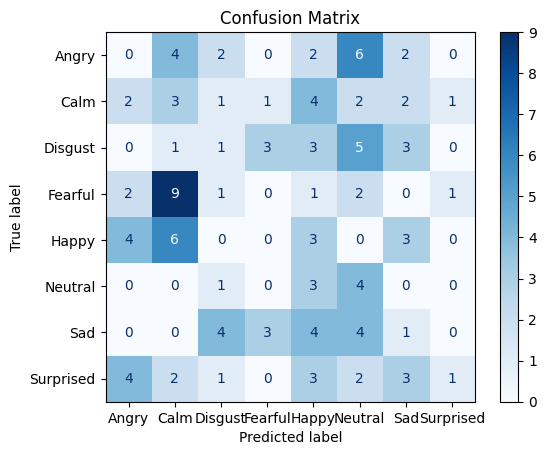

In [ ]:

# Step 7: Generate Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Step 8: Visualize Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [94]:


# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly']
}

# Perform GridSearch
svm = SVC()
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=8, scoring='accuracy')
grid_search.fit(X_train_scaled, Y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Train the model with best parameters
best_svm = grid_search.best_estimator_
best_svm.fit(X_train_scaled, Y_train)

# Evaluate the model
y_pred = best_svm.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Improved Accuracy: {accuracy * 100:.2f}%")


Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Improved Accuracy: 22.50%


Train Accuracy: 99.67%
Test Accuracy: 22.50%
Precision: 31.07%
Recall: 22.50%
F1 Score: 21.51%


c:\Users\KIRTI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


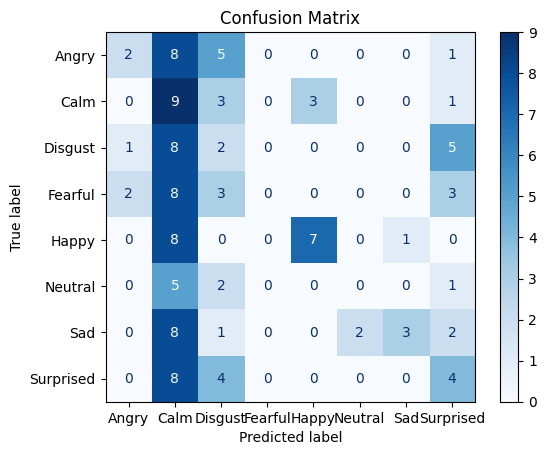

In [96]:

# Predictions on train and test datasets
y_train_pred = best_svm.predict(X_train_scaled)
y_test_pred = best_svm.predict(X_test_scaled)

# Calculate metrics
train_accuracy = accuracy_score(Y_train, y_train_pred)
test_accuracy = accuracy_score(Y_test, y_test_pred)

precision = precision_score(Y_test, y_test_pred, average='weighted')  # Weighted for class imbalance
recall = recall_score(Y_test, y_test_pred, average='weighted')
f1 = f1_score(Y_test, y_test_pred, average='weighted')

# Display metrics
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Generate and plot confusion matrix
cm = confusion_matrix(Y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [106]:
filename='save_best_svm.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_svm, file)

In [98]:
with open('save_best_svm.pkl', 'rb') as file:
    loaded_model = pickle.load(file)